In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from dotenv import load_dotenv
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

import sys
sys.path.append("..")
from src.outliers import detect_outliers_dataframe, winsorize_series

In [18]:
from dotenv import load_dotenv
import os
load_dotenv(PROJECT_ROOT / ".env")

print("DATA_DIR_PROCESSED =", os.getenv("DATA_DIR_PROCESSED"))

DATA_DIR_PROCESSED = data/processed


In [23]:
PROJECT_ROOT = Path().resolve()
load_dotenv(PROJECT_ROOT / ".env")
PROC_DIR = PROJECT_ROOT / os.getenv("DATA_DIR_PROCESSED")

df_cleaned = PROC_DIR / "MSFT_preprocessed.csv"
df = pd.read_csv(df_cleaned, parse_dates=['date'])
print("Loaded Stage6 preprocessed data:", df_cleaned)
print(df.head())

numeric_cols = ['open', 'high', 'low', 'close', 'adj_close', 'volume']

Loaded Stage6 preprocessed data: D:\文心远\研究生\5040-Bootcamp\project\data\processed\MSFT_preprocessed.csv
        date      open      high       low     close  adj_close    volume
0 2025-02-24  0.282016  0.235063  0.291433  0.273028   0.271554  0.309973
1 2025-02-25  0.245755  0.196052  0.277430  0.239342   0.238049  0.372483
2 2025-02-26  0.230634  0.204849  0.264336  0.249448   0.248100  0.165049
3 2025-02-27  0.246587  0.216055  0.253220  0.209686   0.208554  0.197080
4 2025-02-28  0.204453  0.173587  0.223291  0.234316   0.233051  0.445921


Detecting Outliers - IQR & Z-score

In [24]:
numeric_cols = ['open', 'high', 'low', 'close', 'adj_close', 'volume']

# Detect IQR outliers
df_outliers_iqr = detect_outliers_dataframe(df, numeric_cols, method="iqr", k=1.5)

# Detect Z-score outliers
df_outliers_z = detect_outliers_dataframe(df, numeric_cols, method="zscore", threshold=3.0)

# Count outliers per column
print(df_outliers_iqr.sum())
print(df_outliers_z.sum())

df['any_outlier'] = df_outliers_iqr.any(axis=1)

open_outlier_iqr          0
high_outlier_iqr          0
low_outlier_iqr           0
close_outlier_iqr         0
adj_close_outlier_iqr     0
volume_outlier_iqr       12
dtype: int64
open_outlier_z         0
high_outlier_z         0
low_outlier_z          0
close_outlier_z        0
adj_close_outlier_z    0
volume_outlier_z       5
dtype: int64


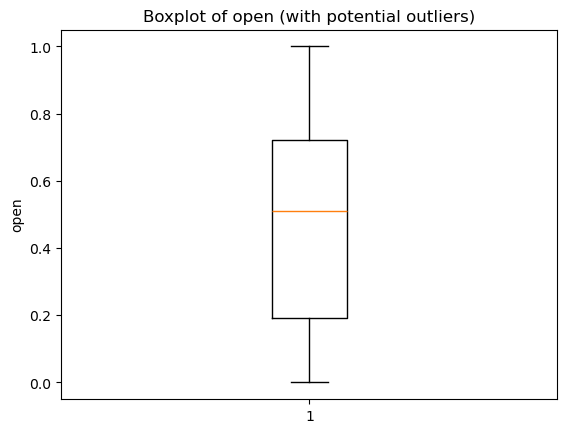

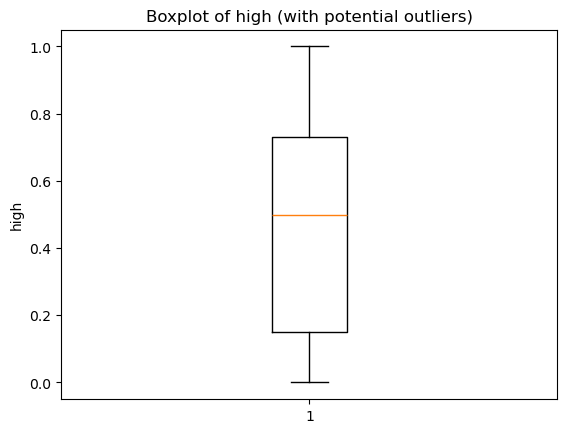

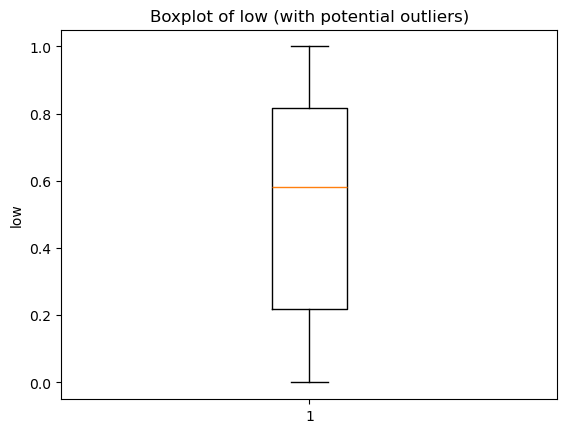

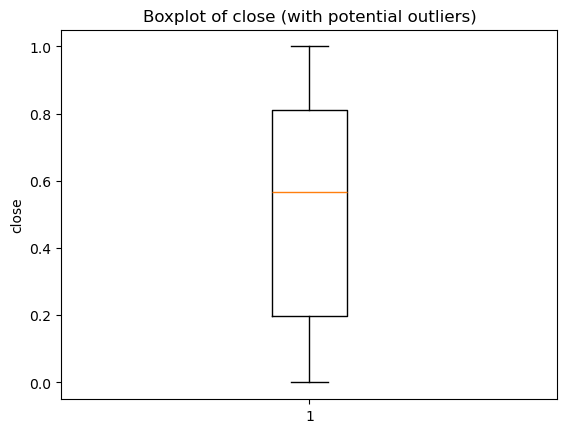

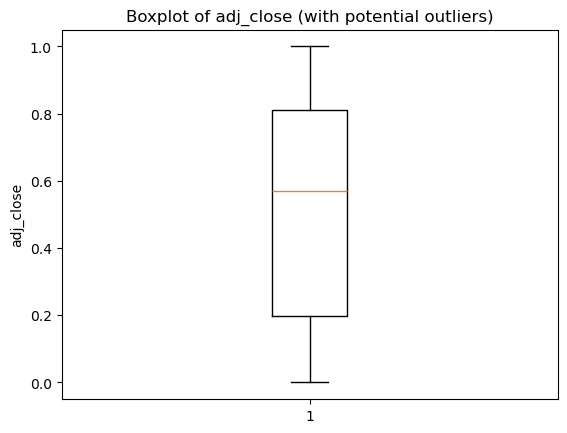

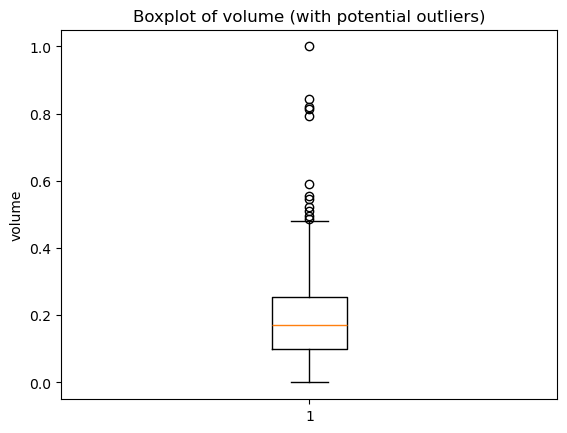

In [26]:
for col in numeric_cols:
    plt.figure()
    plt.boxplot(df[col], vert=True)
    plt.title(f'Boxplot of {col} (with potential outliers)')
    plt.ylabel(col)
    plt.show()

Winsorized

In [28]:
df_winsorized = df.copy()
for col in numeric_cols:
    df_winsorized[f"{col}_w"] = winsorize_series(df[col], lower=0.05, upper=0.95)

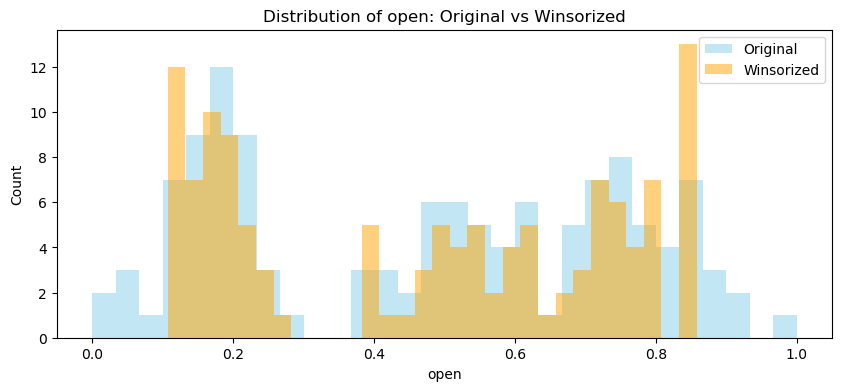

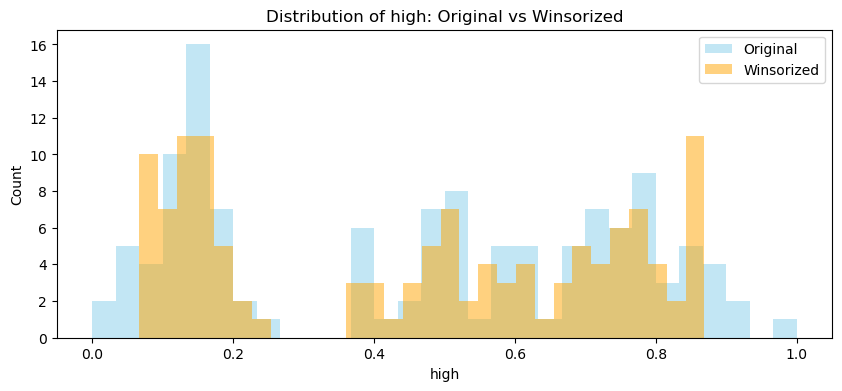

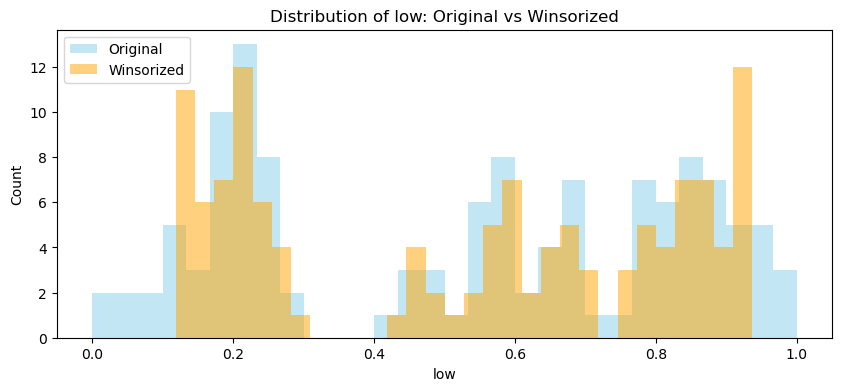

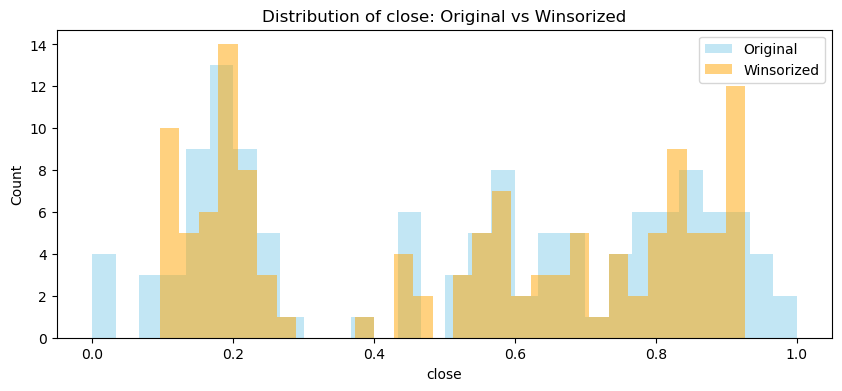

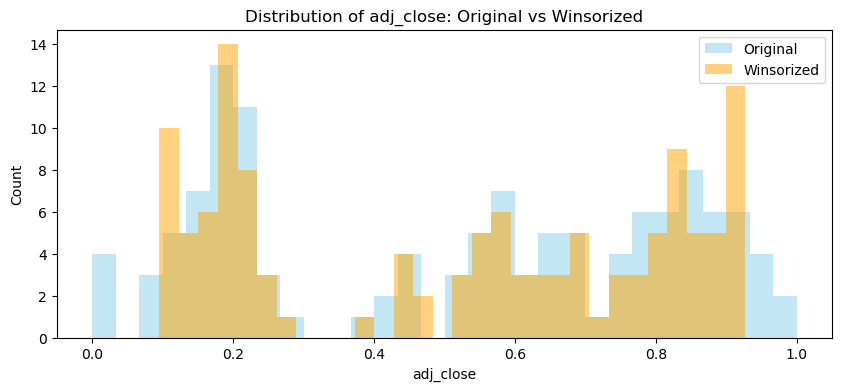

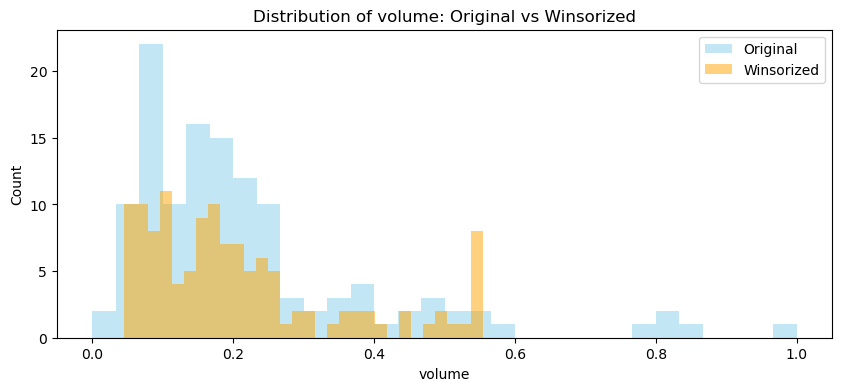

In [30]:
for col in numeric_cols:
    plt.figure(figsize=(10,4))

    # Original vs Winsorized
    plt.hist(df[col], bins=30, alpha=0.5, label='Original', color='skyblue')
    plt.hist(df_winsorized[f"{col}_w"], bins=30, alpha=0.5, label='Winsorized', color='orange')

    plt.title(f'Distribution of {col}: Original vs Winsorized')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend()
    plt.show()


Sensitivity Analysis

In [33]:
def fit_and_metrics(X: np.ndarray, y: np.ndarray) -> dict:
    model = LinearRegression()
    model.fit(X, y)
    y_hat = model.predict(X)
    return {
        'slope': float(model.coef_[0]),
        'intercept': float(model.intercept_),
        'r2': float(r2_score(y, y_hat)),
        'mae': float(mean_absolute_error(y, y_hat))
    }


X = df[['volume']].to_numpy()
y_all = df['adj_close'].to_numpy()
y_filtered = df.loc[~df_outliers_iqr['adj_close_outlier_iqr'], 'adj_close'].to_numpy()
y_winsorized = df_winsorized['adj_close_w'].to_numpy()

metrics_all = fit_and_metrics(X, y_all)
metrics_filtered = fit_and_metrics(X, y_filtered)
metrics_winsorized = fit_and_metrics(X, y_winsorized)

sens_table = pd.DataFrame([metrics_all, metrics_filtered, metrics_winsorized],
                          index=['all', 'filtered_iqr', 'winsorized'])
print(sens_table)

                 slope  intercept        r2       mae
all          -0.487690   0.623733  0.085060  0.250358
filtered_iqr -0.487690   0.623733  0.085060  0.250358
winsorized   -0.471101   0.621157  0.083185  0.246117


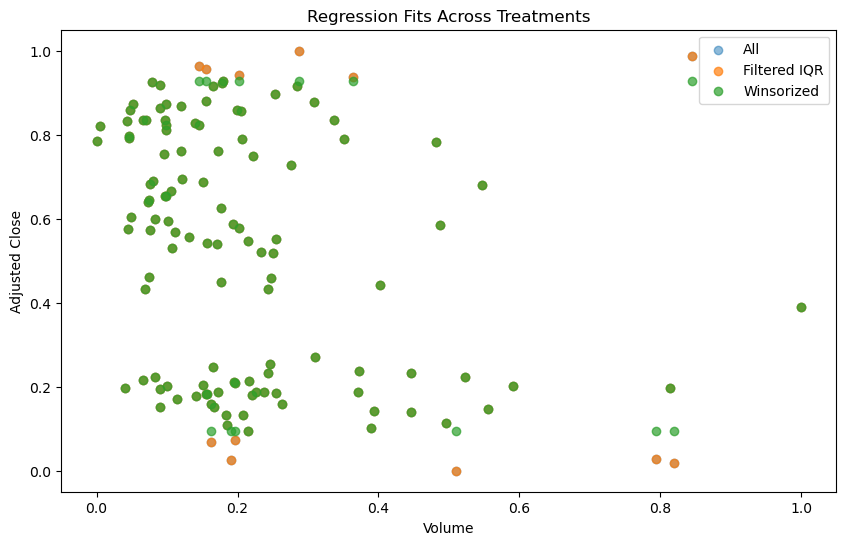

In [36]:

# Regression fit plots
plt.figure(figsize=(10,6))
plt.scatter(df['volume'], df['adj_close'], label='All', alpha=0.5)
plt.scatter(df['volume'][~df_outliers_iqr['adj_close_outlier_iqr']],
            df['adj_close'][~df_outliers_iqr['adj_close_outlier_iqr']],
            label='Filtered IQR', alpha=0.7)
plt.scatter(df['volume'], df_winsorized['adj_close_w'], label='Winsorized', alpha=0.7)
plt.xlabel("Volume")
plt.ylabel("Adjusted Close")
plt.title("Regression Fits Across Treatments")
plt.legend()
plt.show()


In [ ]:
import os
os.chdir("d:/文心远/研究生/5040-Bootcamp/project")  # 切换工作目录
print("Current working dir:", os.getcwd())

Current working dir: d:\文心远\研究生\5040-Bootcamp\project
